## Attempt 2
The idea is to start with an "absolute" mapping of the chords - write some sort of script to see how close we can get to identification without machine learning

then, based on the results, we can see how we can extend it, some examples below:
- using the frequency plot or spectogram as the input to the cnn
- creating an RNN to detect chord patterns
- or some sort of system to detect the key or tonal centre of a piece

In [26]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm


In [3]:
TONE_A = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [9]:
# credit to: https://www.kaggle.com/code/slawagrechaniy/laba5?scriptVersionId=151548405&cellId=5
def plot_freq_file(fileName,FREQ_FROM = TONE_A*2**-2,FREQ_TO = TONE_A*2**4):
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) 
    data = minmax_scale(data,(-1.,1.))
 
    freq_image = fft.rfft(data,norm='forward') 
    freq_scale = fft.rfftfreq(len(data),1./rate)
    
    f_idx = np.where((freq_scale>FREQ_FROM)&(freq_scale<FREQ_TO)) 
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xscale('log',base=2.) # log scale base 2 of freq-> tone change in one octave is freq multiplication by 2 
    plt.plot(freq_scale[f_idx],np.abs(freq_image[f_idx]))
    plt.title('sound signal freq image')
    plt.xlabel('freq, [Hz]')
    plt.xticks((110,220,440,880,1760,3520),('110','220','440','880','1760','3520'))
    plt.ylabel('mode magnitude')

In [33]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


Eb
dim
Ab
maj
Bb
min


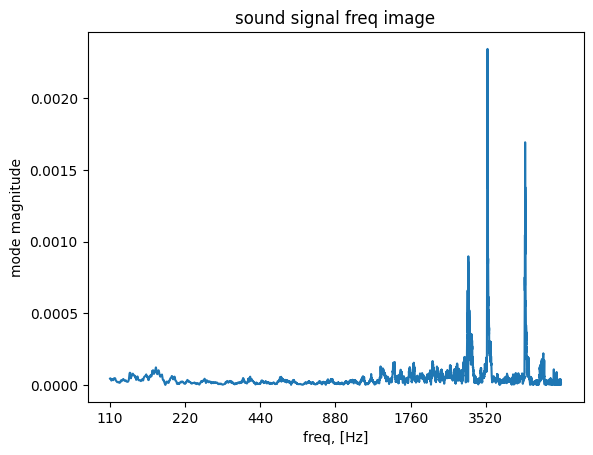

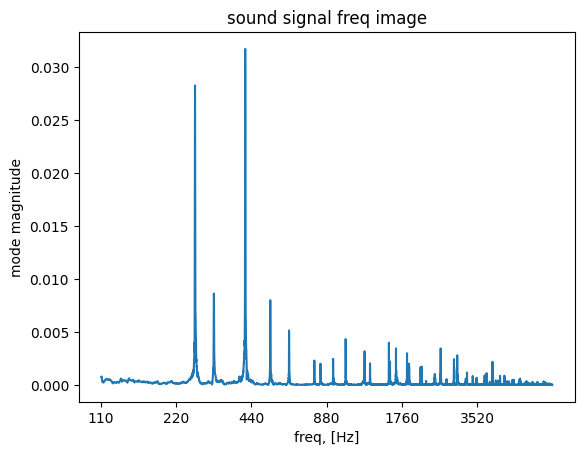

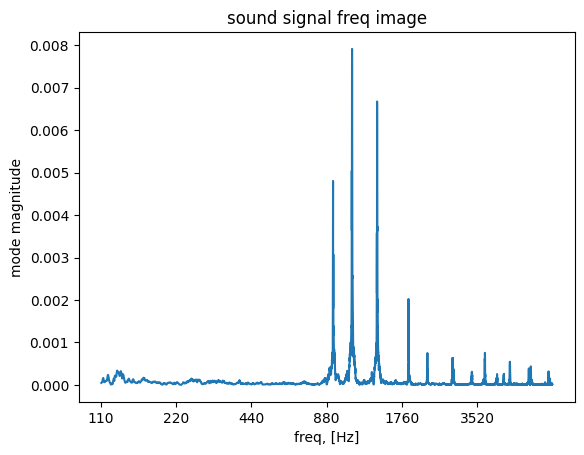

In [15]:
# run plot_freq_file on a few of the files in /data/train_set.csv:
# the file path of the files is in the "File Path Column"
print(train_set['Root Note'].iloc[0])
print(train_set['Quality'].iloc[0])
plot_freq_file(train_set['File Path'].iloc[0])
print(train_set['Root Note'].iloc[2])
print(train_set['Quality'].iloc[2])
plot_freq_file(train_set['File Path'].iloc[2])
print(train_set['Root Note'].iloc[1])
print(train_set['Quality'].iloc[1])
plot_freq_file(train_set['File Path'].iloc[1])


In [44]:
def freq_to_rnote(freq):
    r = 12.0*np.log2(freq/TONE_A)
    return r

def rnote_to_freq(r):
    f = TONE_A*2**(r/12)
    return f

def get_note_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.2):
    """ rnote - name or number of note,fft_image - fourier image of signal,
    fft_freq - frequencies in fft_image,rnote_epsilon - halfwide of window to inspect
    return maximum volume(magnitude) of signal in freq window for rnote """
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    try:
        f0 = rnote_to_freq(rnote-rnote_epsilon)
        f1 = rnote_to_freq(rnote+rnote_epsilon)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except Exception:
        return 0.
    
    return maxVol

def get_notes_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.5,oct_range_from=-2.,oct_range_to=4.):
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    rnotes = np.arange(rnote+12.*oct_range_from,rnote+12.*oct_range_to,12.0)
    vol = []
    for rn in rnotes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    return np.max(vol)

def plot_notes(fileName):
    """convert the fft image from file to notes notations and plot on"""
    #print(fileName)
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.)) 
    fft_image = np.abs(fft.rfft(data,norm='forward')) 
    fft_freq = fft.rfftfreq(len(data),1./rate)
    vol_matrix = np.ndarray(shape=(12),dtype=np.float32)
    for rnote in range(12):
        vol_matrix[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
        
    plt.bar(NOTES, vol_matrix)
    plt.show()

Eb
dim


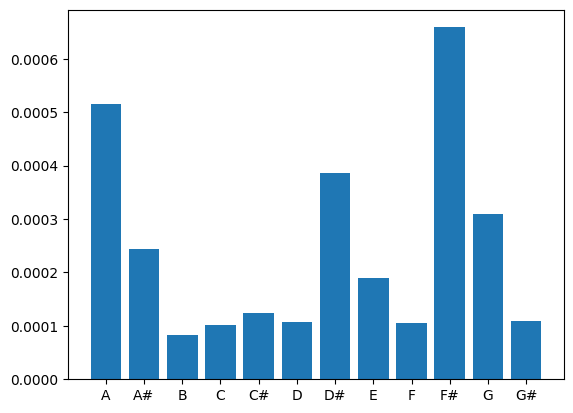

None
Ab
maj


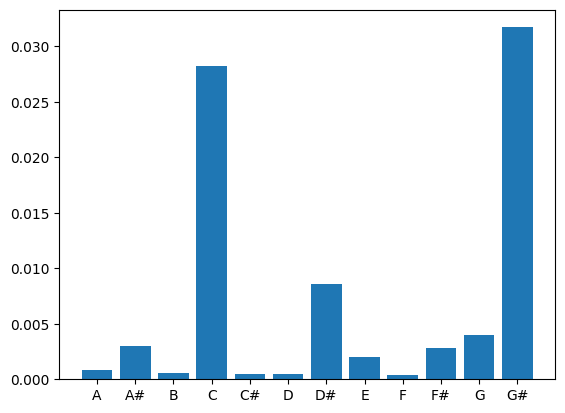

None
Bb
min


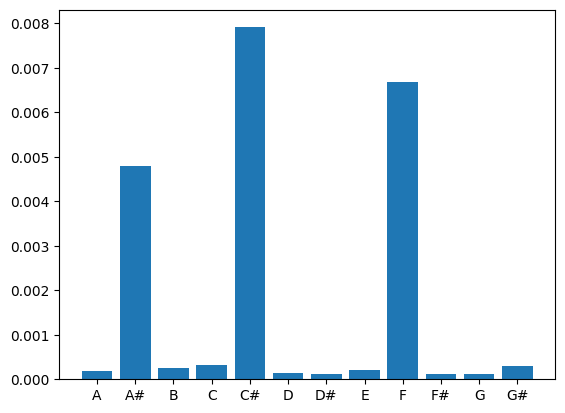

None


In [20]:
print(train_set['Root Note'].iloc[0])
print(train_set['Quality'].iloc[0])
print(plot_notes(train_set['File Path'].iloc[0]))
print(train_set['Root Note'].iloc[2])
print(train_set['Quality'].iloc[2])
print(plot_notes(train_set['File Path'].iloc[2]))
print(train_set['Root Note'].iloc[1])
print(train_set['Quality'].iloc[1])
print(plot_notes(train_set['File Path'].iloc[1]))


In [49]:
def chord_quality(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    major_vol = []
    minor_vol = []
    diminished_vol = []
    augmented_vol = []

    for rnote in range(12):
        vol = get_notes_volume(rnote,fft_image,fft_freq)
        v3 = get_notes_volume((rnote+3)%12,fft_image,fft_freq)
        v4 = get_notes_volume((rnote+4)%12,fft_image,fft_freq)
        v6 = get_notes_volume((rnote+6)%12,fft_image,fft_freq)
        v7 = get_notes_volume((rnote+7)%12,fft_image,fft_freq)
        v8 = get_notes_volume((rnote+8)%12,fft_image,fft_freq)

        major_vol.append(vol + v4 + v7)
        minor_vol.append(vol + v3 + v7)
        diminished_vol.append(vol + v3 + v6)
        augmented_vol.append(vol + v4 + v8)
    
    major_max = [max(major_vol), NOTES[major_vol.index(max(major_vol))]]
    minor_max = [max(minor_vol), NOTES[minor_vol.index(max(minor_vol))]] 
    diminished_max = [max(diminished_vol), NOTES[diminished_vol.index(max(diminished_vol))]] 
    augmented_max = [max(augmented_vol), NOTES[augmented_vol.index(max(augmented_vol))]] 

    if max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == major_max[0]:
        return 'maj', major_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == minor_max[0]:
        return 'min', minor_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == diminished_max[0]:
        return 'dim', diminished_max[1]
    else:
        return 'aug', augmented_max[1]

In [34]:
# print a summary of the chord qualities in the train set
print(train_set['Quality'].value_counts())

Quality
aug    179
dim    178
min    178
maj    178
Name: count, dtype: int64


In [51]:
# test this function on the entire training set (by checking if chord_quality matches the Quality column)
# and report the accuracy of the function

# i just want this to be calculated, not saved to the dataframe
major_correct = 0
major_incorrect = 0
minor_correct = 0
minor_incorrect = 0
# calculate this for diminished and augmented chords as well
diminished_correct = 0
diminished_incorrect = 0
augmented_correct = 0
augmented_incorrect = 0

root_note_correct = 0
root_note_incorrect = 0

for i in tqdm(range(len(train_set))):
    quality, root_note = chord_quality(train_set['File Path'].iloc[i])
    if train_set['Quality'].iloc[i] == 'maj':
        if quality == 'maj':
            major_correct += 1
        else:
            major_incorrect += 1
    elif train_set['Quality'].iloc[i] == 'min':
        if quality == 'min':
            minor_correct += 1
        else:
            minor_incorrect += 1
    elif train_set['Quality'].iloc[i] == 'dim':
        if quality == 'dim':
            diminished_correct += 1
        else:
            diminished_incorrect += 1
    elif train_set['Quality'].iloc[i] == 'aug':
        if quality == 'aug':
            augmented_correct += 1
        else:
            augmented_incorrect += 1
    
    if root_note != train_set['Root Note'].iloc[i] and train_set['Quality'].iloc[i] != 'aug':
        root_note_incorrect += 1
    else:
        root_note_correct += 1

print('major correct: ', major_correct)
print('major incorrect: ', major_incorrect)
print('minor correct: ', minor_correct)
print('minor incorrect: ', minor_incorrect)
print('diminished correct: ', diminished_correct)
print('diminished incorrect: ', diminished_incorrect)
print('augmented correct: ', augmented_correct)
print('augmented incorrect: ', augmented_incorrect)
print('root note correct: ', root_note_correct)
print('root note incorrect: ', root_note_incorrect)

print('major accuracy: ', major_correct/(major_correct+major_incorrect))
print('minor accuracy: ', minor_correct/(minor_correct+minor_incorrect))
print('diminished accuracy: ', diminished_correct/(diminished_correct+diminished_incorrect))
print('augmented accuracy: ', augmented_correct/(augmented_correct+augmented_incorrect))
print('root note accuracy: ', root_note_correct/(root_note_correct+root_note_incorrect))
# show overall accuracy
print('overall chord quality accuracy: ', (major_correct+minor_correct+diminished_correct+augmented_correct)/(major_correct+major_incorrect+minor_correct+minor_incorrect+diminished_correct+diminished_incorrect+augmented_correct+augmented_incorrect))


100%|██████████| 713/713 [00:05<00:00, 121.23it/s]

major correct:  158
major incorrect:  20
minor correct:  169
minor incorrect:  9
diminished correct:  151
diminished incorrect:  27
augmented correct:  142
augmented incorrect:  37
root note correct:  520
root note incorrect:  193
major accuracy:  0.8876404494382022
minor accuracy:  0.949438202247191
diminished accuracy:  0.848314606741573
augmented accuracy:  0.7932960893854749
root note accuracy:  0.729312762973352
overall chord quality accuracy:  0.8695652173913043
